In [1]:
height = 96
width = 1408
max_text_length = 0
batch_size = 32
learning_rate = 0.0001
train_epochs = 1000
train_workers = 20
vocab=""

In [9]:
import sys
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../src')
from ocr.helpers import implt, resize, ratio
from ocr import page

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0)

In [3]:
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers as layers

In [4]:
import os
from tqdm import tqdm
import csv



# Paths for datasets
sentences_txt_path = "./data/metadata/sentences.txt"
sentences_folder_path = "./data/dataset"

# Load and process dataset
dataset, vocab, max_len = [], set(), 0
words = open(sentences_txt_path, "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[2] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = "-".join(line_split[0].split("-")[:2])
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip("\n")

    # replace "|" with " " in label
    label = label.replace("|", " ")

    rel_path = os.path.join(sentences_folder_path, file_name)
    if not os.path.exists(rel_path):
        print(f"File not found: {rel_path}")
        continue

    dataset.append([rel_path, label])
    max_len = max(max_len, len(label))


max_text_length = max_len



csv_file_path = "data.csv"

# Write the data to the CSV file with labeled columns
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row with labeled columns
    writer.writerow(["path", "label"])
    
    # Write the data
    writer.writerows(dataset)

print("CSV file has been created successfully.")

100%|██████████| 16777/16777 [00:00<00:00, 18434.35it/s]

CSV file has been created successfully.


In [5]:
data = pd.read_csv("./data.csv")

In [6]:
data.head()

,path,label
0,./data/dataset\a01-000u-s00-00.png,A MOVE to stop Mr. Gaitskell from
1,./data/dataset\a01-000u-s00-01.png,nominating any more Labour life Peers
2,./data/dataset\a01-000u-s00-02.png,is to be made at a meeting of Labour
3,./data/dataset\a01-000u-s01-01.png,put down a resolution on the subject
4,./data/dataset\a01-000u-s01-03.png,P for Manchester Exchange .


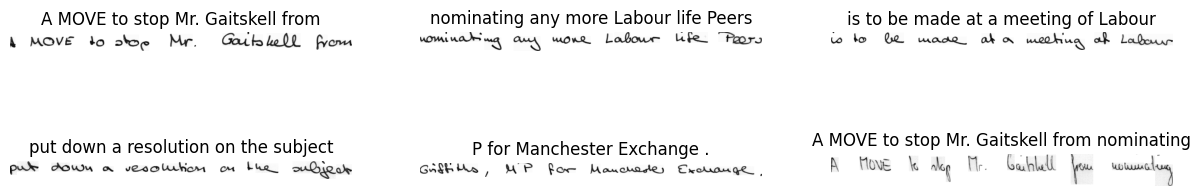

In [7]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(data.loc[i, 'label'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)


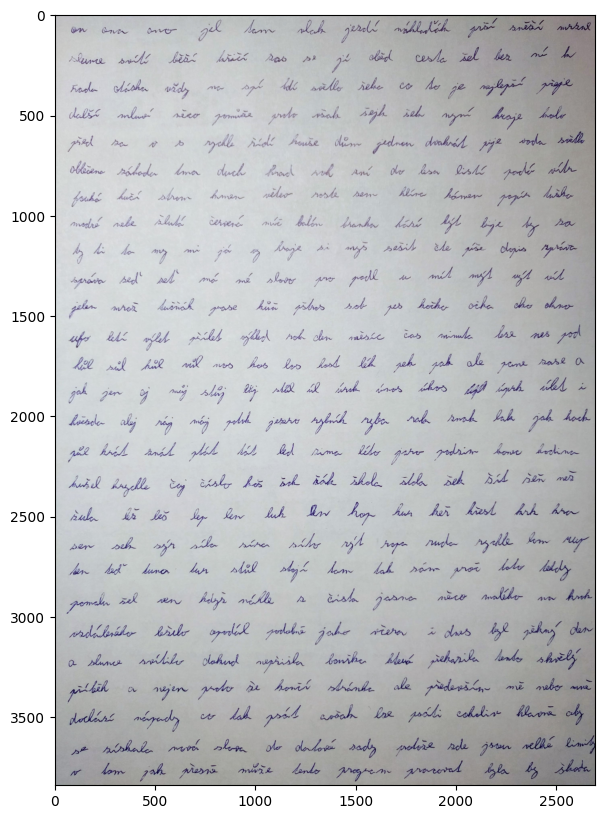

In [177]:
# Assuming IMG is defined somewhere in your script
# IMG = 'h04-035-s00-00'  # Replace this with the actual value of IMG

# image_path = os.path.join(".", "data", "dataset", f"{IMG}.png")
# if not os.path.exists(image_path):
#     raise FileNotFoundError(f"Image file not found: {image_path}")

IMG = 'text4'  # Replace this with the actual value of IMG

image_path = os.path.join(".", "data", "dataset", f"{IMG}.jpg")
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found: {image_path}")

image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Failed to load image from path: {image_path}")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
implt(image_rgb)

In [129]:
# SMALL_HEIGHT = 800

# def resize(img, height=SMALL_HEIGHT, always=False):
#     if (img.shape[0] > height or always):
#         rat = height / img.shape[0]
#         return cv2.resize(img, (int(rat * img.shape[1]), height))
#     return img

# def ratio(img, height=SMALL_HEIGHT):
#     return img.shape[0] / height

# def edges_det(img, min_val, max_val):
#     """ Preprocessing (gray, thresh, filter, border) + Canny edge detection """
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = cv2.bilateralFilter(img, 9, 75, 75)
#     img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
#     img = cv2.medianBlur(img, 11)
#     img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])
#     return cv2.Canny(img, min_val, max_val)

# def four_corners_sort(pts):
#     """ Sort corners: top-left, bot-left, bot-right, top-right"""
#     diff = np.diff(pts, axis=1)
#     summ = pts.sum(axis=1)
#     return np.array([pts[np.argmin(summ)],
#                      pts[np.argmax(diff)],
#                      pts[np.argmax(summ)],
#                      pts[np.argmin(diff)]])

# def contour_offset(cnt, offset):
#     """ Offset contour because of 5px border """
#     cnt += offset
#     cnt[cnt < 0] = 0
#     return cnt

In [119]:
# def find_page_contours(edges, img):
#     """ Finding corner points of page contour """
#     contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     height = edges.shape[0]
#     width = edges.shape[1]
#     MIN_COUNTOUR_AREA = height * width * 0.5
#     MAX_COUNTOUR_AREA = (width - 10) * (height - 10)
#     max_area = MIN_COUNTOUR_AREA
#     page_contour = np.array([[0, 0],
#                              [0, height-5],
#                              [width-5, height-5],
#                              [width-5, 0]])

#     for cnt in contours:
#         perimeter = cv2.arcLength(cnt, True)
#         approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)
#         if (len(approx) == 4 and
#                 cv2.isContourConvex(approx) and
#                 max_area < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):
#             max_area = cv2.contourArea(approx)
#             page_contour = approx[:, 0]

#     page_contour = four_corners_sort(page_contour)
#     return contour_offset(page_contour, (-5, -5))

# # Example usage (make sure edges and img are defined):
# # edges = cv2.Canny(image, 100, 200)
# # page_contours = find_page_contours(edges, image)

In [130]:
# # Directory containing images
# image_directory = "./data/dataset"
# processed_files = []

# # Loop over all images in the directory
# for filename in os.listdir(image_directory):
#     if filename.endswith(".png"):  # You can add other image extensions if needed
#         image_path = os.path.join(image_directory, filename)
#         image = cv2.imread(image_path)
#         if image is None:
#             print(f"Failed to load image: {image_path}")
#             continue

#         small = resize(image)
#         edges_image = edges_det(small, 200, 250)
#         edges_image = cv2.morphologyEx(edges_image, cv2.MORPH_CLOSE, np.ones((5, 11)))

#         page_contour = find_page_contours(edges_image, small)
#         page_contour = page_contour.dot(ratio(image, small.shape[0]))

#         # Add the processed file name to the list
#         processed_files.append(filename)
        
#         # Print the list of processed files
#         # print("Processed files with background removed:")
#         print(file)

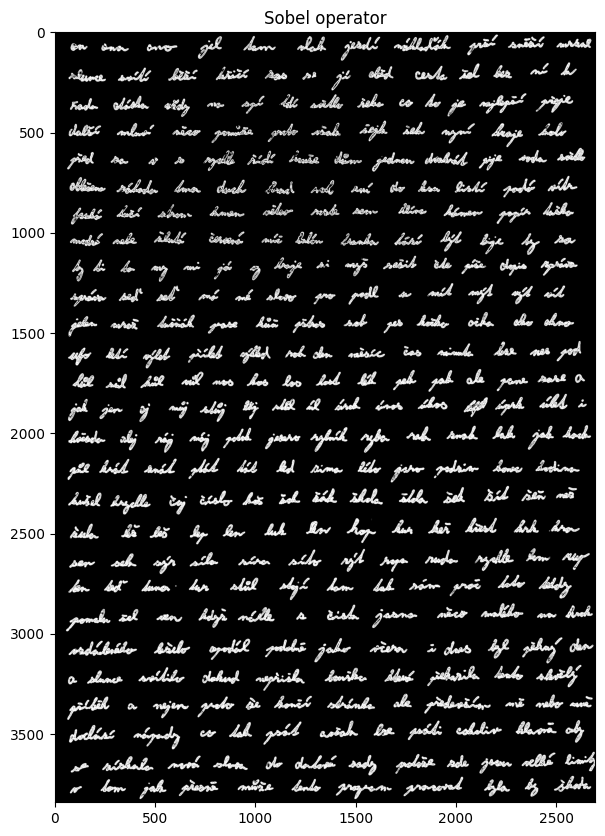

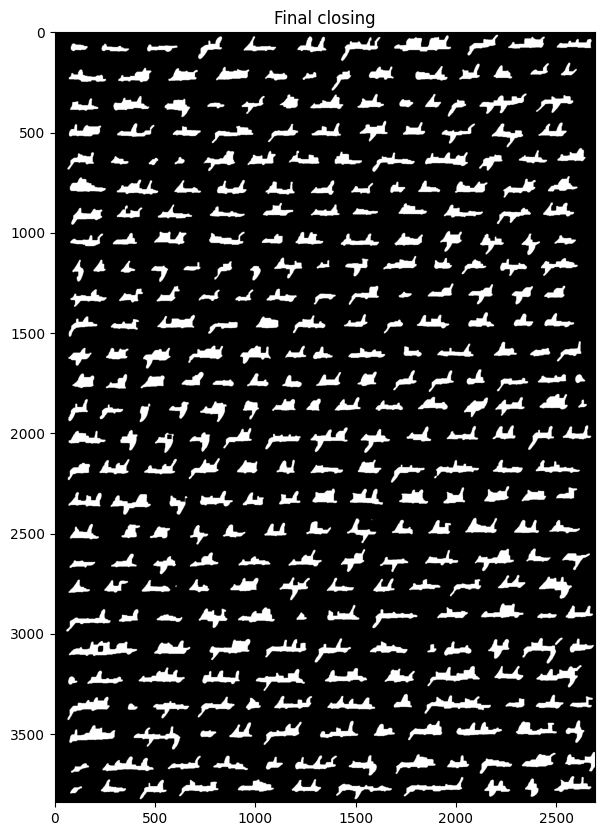

In [178]:
# def implt(img, cmp='gray', t=''):
#     """ Helper function to display an image """
#     plt.imshow(img, cmap=cmp)
#     plt.title(t)
#     plt.show()

def sobel(channel):
    """ The Sobel Operator"""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    # Combine x, y gradient magnitudes sqrt(x^2 + y^2)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return np.uint8(sobel)

def edge_detect(im):
    """ 
    Edge detection 
    The Sobel operator is applied for each image layer (RGB)
    """
    return np.max(np.array([sobel(im[:, :, 0]), sobel(im[:, :, 1]), sobel(im[:, :, 2])]), axis=0)

# Image pre-processing - blur, edges, threshold, closing
blurred = cv2.GaussianBlur(image_rgb, (5, 5), 18)
edges = edge_detect(blurred)
ret, edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)
bw_image = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((20, 20), np.uint8))

implt(edges, 'gray', 'Sobel operator')
implt(bw_image, 'gray', 'Final closing')

# # Remove lines and big areas
# bw_image = del_lines(bw_image)
# del_big_areas(image_rgb)

In [179]:
def del_lines(gray):
    """ Delete page lines """
    linek = np.ones((1, 11), np.uint8)
    x = cv2.morphologyEx(gray, cv2.MORPH_OPEN, linek, iterations=1)
    i = gray - x
    closing = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((17, 17), np.uint8))
    implt(closing, 'gray', 'Del Lines')
    return closing

def del_big_areas(img):
    """ Find and remove contours too big for a word """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 101, 3)
    implt(gray, 'gray')
    
    gray2 = gray.copy()
    mask = np.zeros(gray.shape, np.uint8)
    
    contours_info = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours_info) == 3:
        im2, contours, hierarchy = contours_info
    else:
        contours, hierarchy = contours_info
    
    for cnt in contours:
        if 200 < cv2.contourArea(cnt) < 5000:
            cv2.drawContours(img, [cnt], 0, (0, 255, 0), 2)
            cv2.drawContours(mask, [cnt], 0, 255, -1)
            
    implt(mask)
    implt(img)

In [180]:
def union(a, b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0] + a[2], b[0] + b[2]) - x
    h = max(a[1] + a[3], b[1] + b[3]) - y
    return [x, y, w, h]

def intersect(a, b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0] + a[2], b[0] + b[2]) - x
    h = min(a[1] + a[3], b[1] + b[3]) - y
    if w < 0 or h < 0:
        return False
    return True

def group_rectangles(rec):
    """
    Union intersecting rectangles
    Args:
        rec - list of rectangles in form [x, y, w, h]
    Return:
        list of grouped rectangles 
    """
    tested = [False for _ in range(len(rec))]
    final = []
    i = 0
    while i < len(rec):
        if not tested[i]:
            j = i + 1
            while j < len(rec):
                if not tested[j] and intersect(rec[i], rec[j]):
                    rec[i] = union(rec[i], rec[j])
                    tested[j] = True
                    j = i
                j += 1
            final += [rec[i]]
        i += 1
    return final


In [181]:
def text_detect(img, original):
    """ Text detection using contours """
    # Resize image
    small = resize(img, 2000)
    image = resize(original, 2000)
    
    # Finding contours
    mask = np.zeros(small.shape, np.uint8)
    contours_info = cv2.findContours(np.copy(small), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours_info) == 3:
        im2, cnt, hierarchy = contours_info
    else:
        cnt, hierarchy = contours_info

    implt(img, 'gray')
    
    # Variables for contour index and words' bounding boxes
    index = 0    
    boxes = []
    # CCOMP hierarchy: [Next, Previous, First Child, Parent]
    # cv2.RETR_CCOMP - contours into 2 levels
    # Go through all contours in first level
    while index >= 0:
        x, y, w, h = cv2.boundingRect(cnt[index])
        # Get only the contour
        cv2.drawContours(mask, cnt, index, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text (white pixel ratio, width, height)
        if r > 0.1 and 2000 > w > 10 and 1600 > h > 10 and h/w < 3 and w/h < 10:
            boxes += [[x, y, w, h]]
        
        # Index of next contour
        index = hierarchy[0][index][0]
        
    # Group intersecting rectangles
    boxes = group_rectangles(boxes)
    bounding_boxes = np.array([0, 0, 0, 0])
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 8)
        bounding_boxes = np.vstack((bounding_boxes, np.array([x, y, x + w, y + h])))

    implt(image, t='Bounding rectangles')

    # Recalculate coordinates to original scale
    boxes = bounding_boxes.dot(ratio(original, small.shape[0])).astype(np.int64)
    return boxes[1:] 

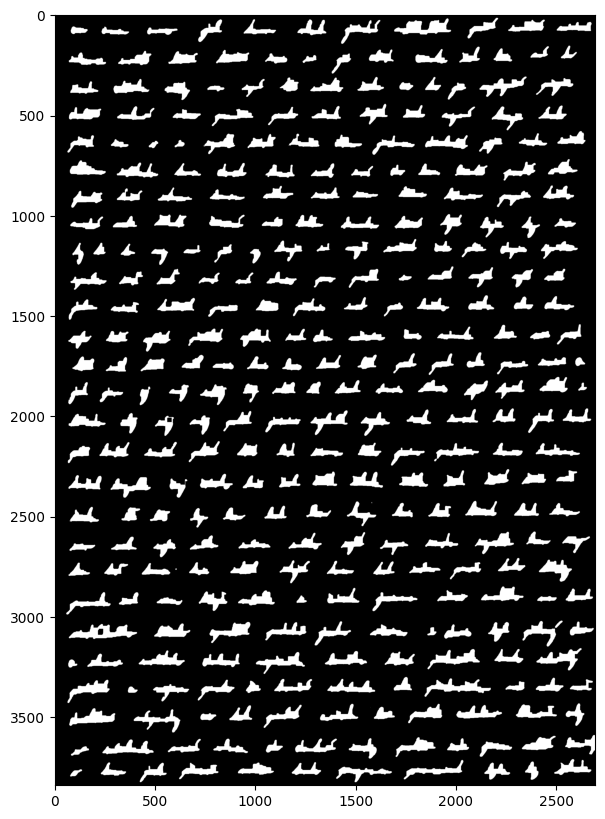

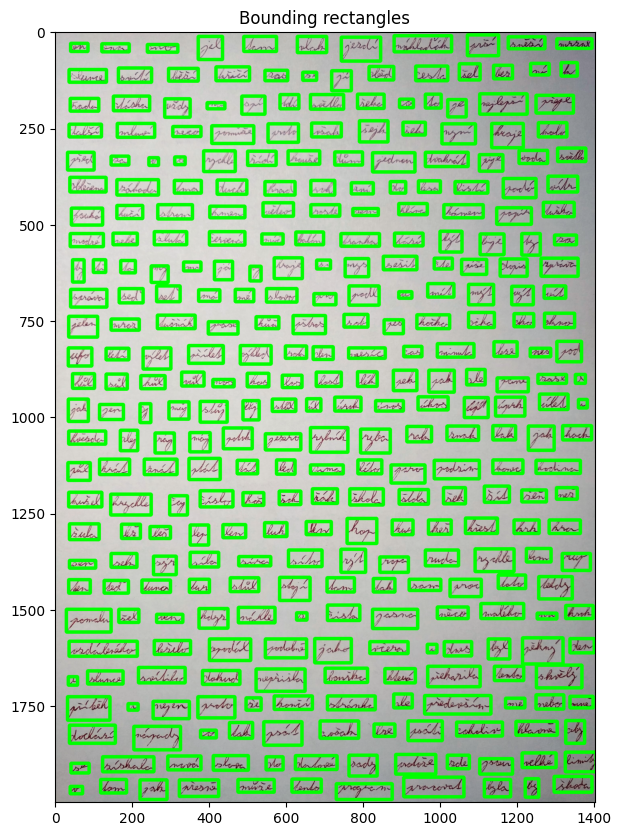

Number of boxes: 333


In [182]:
# Get text bounding boxes
boxes = text_detect(bw_image, image)
print("Number of boxes:", len(boxes))

In [184]:
def textDetectWatershed(thresh, original):
    """ Text detection using watershed algorithm """
    # Resize images
    img = resize(original, 3000)
    thresh = resize(thresh, 3000)
    
    # Noise removal
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)
    
    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.01 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers += 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0
    
    markers = cv2.watershed(img, markers)
    implt(markers, t='Markers')
    image = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Creating result array
    boxes = []
    for mark in np.unique(markers):
        # mark == 0 --> background
        if mark == 0:
            continue

        # Draw it on mask and detect biggest contour
        mask = np.zeros(gray.shape, dtype="uint8")
        mask[markers == mark] = 255

        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
        c = max(cnts, key=cv2.contourArea)
        
        # Draw a bounding rectangle if it contains text
        x, y, w, h = cv2.boundingRect(c)
        cv2.drawContours(mask, c, 0, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y + h, x:x + w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text
        if r > 0.1 and 2000 > w > 15 and 1500 > h > 15:
            boxes += [[x, y, w, h]]
    
    # Group intersecting rectangles
    boxes = group_rectangles(boxes)
    bounding_boxes = np.array([0, 0, 0, 0])
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 8)
        bounding_boxes = np.vstack((bounding_boxes, np.array([x, y, x + w, y + h])))
        
    implt(image)

    # Recalculate coordinates to original size
    boxes = bounding_boxes.dot(ratio(original, img.shape[0])).astype(np.int64)
    return boxes[1:]  

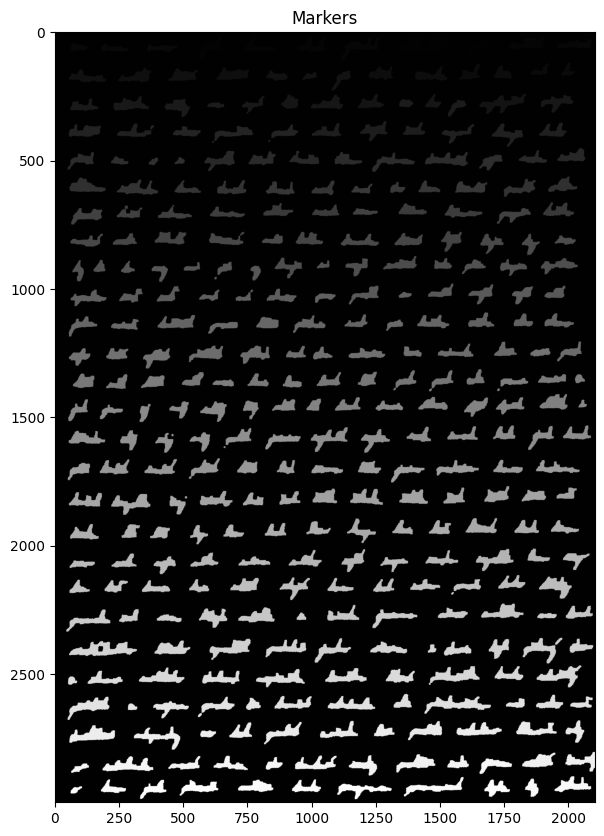

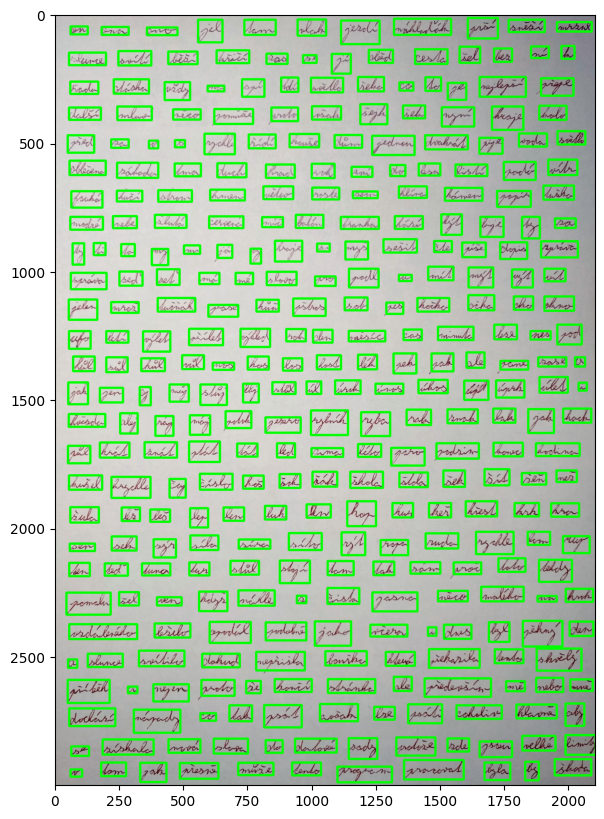

Number of boxes: 333


In [185]:
# Testing different alg - Watershed
boxes = textDetectWatershed(bw_image, image)
print("Number of boxes:", len(boxes))